In [1]:
#!pip install selenium

In [2]:
import selenium 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import csv 
import shutil
import os

In [3]:
#Definate a function for geting data
def extract_data(driver):
    pages=driver.find_elements("xpath", "//div[@data-test-id='pinWrapper']/div[1]/div[1]/div[1]")
    for i in range (len(pages)):
        try:
            xpath='/html/body/div[1]/div/div[1]/div/div[2]/div/div/div[4]/div/div[1]/div/div/div/div[1]/div['+str(i+1)+']/div/div/div/div/div/div[1]/div[1]/a'
            link=pages[i].find_element("xpath",xpath).get_attribute('href')
            link_list.append(link)
            sleep(2)
        except:
            pass
#Definate a function for moving pictures
def move_file(source_path, destination_folder):
    # make sure the file exist
    os.makedirs(destination_folder, exist_ok=True)

    # move
    shutil.move(source_path, os.path.join(destination_folder, os.path.basename(source_path)))
#search
search_list=['photoshoot']
for title in search_list:
    #searching information about Library
    url="https://www.pinterest.co.uk/"
    link_list=[]
    pictures_list=[]
    driver = webdriver.Chrome()
    driver.get(url)
    sleep(3)
    #log in
    button = driver.find_element("xpath","/html/body/div[1]/div/div[1]/div/div/div/div/div[1]/div/div[2]/div[2]/button")
    button.click()
    username = driver.find_element("id","email")
    username.send_keys('zhuolan0418@gmail.com')
    sleep(3)
    password = driver.find_element("id","password")
    password.send_keys('Zhuolan200418')
    login = driver.find_element("xpath","/html/body/div[1]/div/div[1]/div[2]/div/div/div/div/div/div[4]/form/div[7]/button/div")
    sleep(3)
    login.click()
    sleep(7)
    search_query = driver.find_element("name","searchBoxInput")
    search_query.send_keys(title)
    search_query.send_keys(Keys.RETURN)
    sleep(3)
    #load more information
    for t in range(0,300):
        driver.find_element("xpath", "/html/body").send_keys(Keys.SPACE)
        extract_data(driver)
        sleep(2)
    #delet dupilcated data
    links=[]
    for a in link_list:
        if a not in links:
            links.append(a)
    #save link in a csv chart
    csvname=str(title)+'.csv'
    with open(csvname, 'w',newline='') as csvfile: 
        writer = csv.writer(csvfile) 
        for link in links:
            writer.writerow([link])
    #download pictures
    with open(csvname, 'r',encoding='utf-8') as file:
        csvreader = csv.reader(file)

        for url in csvreader:
            try:
                driver.get(url[0])
                sleep(2)
                button = driver.find_element("xpath","//div[@data-test-id='pin-action-bar']/div[1]/div[1]/div[1]/div[1]")
                button.click()
                button = driver.find_element("xpath","/html/body/div[3]/div/div/div/div/div[1]/div/div/div[1]/div/div")
                button.click()
                sleep(2)
            except:
                pass
    driver.quit()
    path='/Users/zhuolan/Downloads'
    fileList=os.listdir(path)
    n=0
    for i in fileList:

        #setting oldname of file
        oldname=path+ os.sep + fileList[n]   # os.sep add a seperate note

        #setting newname of file
        newname=path + os.sep +'pic'+'_'+str(n+1)+'.JPG'
        
        os.rename(oldname,newname)   #using os to rename file
        source_file_path = newname
        destination_folder = "/Users/zhuolan/Image input/"+str(title)+' Image'
        move_file(source_file_path, destination_folder)
        n+=1

In [3]:
import tensorflow as tf
import PIL
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np
from subprocess import call
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from decimal import Decimal, localcontext

from pathlib import Path

In [4]:
def opF(path):
    p = Path(path)
    _ = call(['open',p]) # for Mac/Linux

In [5]:
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [6]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [7]:
x = Dropout(rate=0.4)(model.output)
# This determines the number of outputs, and thus the number of categories, in my test case 2: dog or cat
x = Dense(4)(x)
x = Softmax()(x)
model= Model(model.inputs, x)


In [8]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [9]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)

In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    'Image input', 
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    'Image input',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
) 

Found 1575 images belonging to 4 classes.
Found 173 images belonging to 4 classes.


In [14]:
batch_size = 45

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    # this needs to be much higher than 1, but for demo here we'll keep it at this
    epochs=2,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/2
35/35 [==============================] - 36s 1s/step - loss: 0.5907 - val_loss: 0.4350
Epoch 2/2
35/35 [==============================] - 35s 995ms/step - loss: 0.5561 - val_loss: 0.5196


In [15]:
random_oldpainting = random.choice(os.listdir('/Users/zhuolan/Image input/old painting Image'))
oldpainting_path = os.path.join('/Users/zhuolan/Image input/old painting Image',random_oldpainting)
oldpainting = load_image(oldpainting_path)
random_oldpictures = random.choice(os.listdir('/Users/zhuolan/Image input/old pictures Image'))
oldpictures_path = os.path.join('/Users/zhuolan/Image input/old pictures Image',random_oldpictures)
oldpictures = load_image(oldpictures_path)
random_photoshoot = random.choice(os.listdir('/Users/zhuolan/Image input/photoshoot Image'))
photoshoot_path = os.path.join('/Users/zhuolan/Image input/photoshoot Image',random_photoshoot)
photoshoot = load_image(photoshoot_path)
random_AIdrawings = random.choice(os.listdir('/Users/zhuolan/Image input/artificial intelegent art Image'))
AIdrawings_path = os.path.join('/Users/zhuolan/Image input/artificial intelegent art Image',random_AIdrawings)
AIdrawings = load_image(AIdrawings_path)

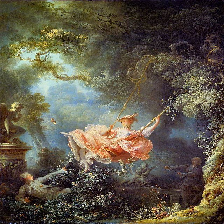

In [16]:
tf.keras.preprocessing.image.load_img(oldpainting_path, target_size=(224,224))

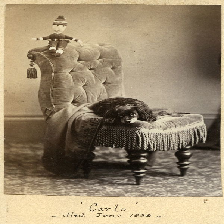

In [17]:
tf.keras.preprocessing.image.load_img(oldpictures_path, target_size=(224,224))

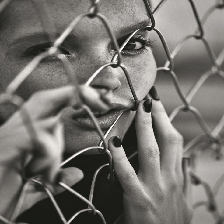

In [18]:
tf.keras.preprocessing.image.load_img(photoshoot_path, target_size=(224,224))

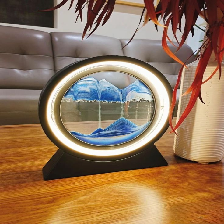

In [19]:
tf.keras.preprocessing.image.load_img(AIdrawings_path, target_size=(224,224))

In [20]:
print(f'''oldpainting:{np.round(model.predict(oldpainting),2)}''')

1/1 [==============================] - 0s 213ms/step
oldpainting:[[0.13 0.85 0.   0.01]]


In [21]:
print(f'''oldpictures:{np.round(model.predict(oldpictures),2)}''')

1/1 [==============================] - 0s 35ms/step
oldpictures:[[0.01 0.01 0.96 0.03]]


In [22]:
print(f'''photoshoot:{np.round(model.predict(photoshoot),2)}''')

1/1 [==============================] - 0s 28ms/step
photoshoot:[[0.01 0.   0.04 0.95]]


In [23]:
print(f'''AIdrawings:{np.round(model.predict(AIdrawings),2)}''')

1/1 [==============================] - 0s 38ms/step
AIdrawings:[[0.97 0.   0.   0.03]]


In [24]:
test_pic = '/Users/zhuolan/Documents/UD/design course term 1/Relic/Agucchi Image/pic_1.JPG'
pic = load_image(test_pic)

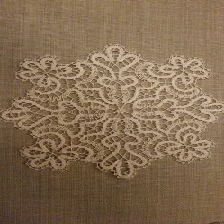

In [25]:
tf.keras.preprocessing.image.load_img(test_pic, target_size=(224,224))

In [26]:
np.round(model.predict(pic),2)

1/1 [==============================] - 0s 36ms/step


array([[0.94, 0.02, 0.04, 0.  ]], dtype=float32)

In [32]:
def create_folder_if_not_exists(folder_path):
    # check whether there is a folder
    if not os.path.exists(folder_path):
        # if not create one
        os.makedirs(folder_path)

In [33]:
directory_path = '/Users/zhuolan/Documents/UD/design course term 1/Relic'

# Get a list of all items (files and directories) in the specified directory
all_items = os.listdir(directory_path)

# Filter out only directories
subdirectories = [item for item in all_items if os.path.isdir(os.path.join(directory_path, item))]

# Now, you can iterate over the subdirectories and list their contents
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(directory_path, subdirectory)
    images = os.listdir(subdirectory_path)
    print(images)
    for i in images:
        if i!='.DS_Store':
            try:
                image_path=os.path.join(subdirectory_path, i)
                image = load_image(image_path)
                k=tf.keras.preprocessing.image.load_img(image_path, target_size=(224,224))
                score=np.round(model.predict(image),2)
                score_list=np.array(score)
                score_list=score_list.tolist()
                ai_score=score_list[0][0]
                oldpainting_score=score_list[0][1]
                oldpictures_score=score_list[0][2]
                photoshoot_score=score_list[0][3]
                dict={'ai_score':ai_score,'oldpainting_score':oldpainting_score,'oldpictures_score':oldpictures_score,'photoshoot_score':photoshoot_score}
                max_key = max(dict, key=dict.get)
                if max_key=='ai_score':
                    destination_folder =os.path.join(subdirectory_path, 'AIdrawings')
                    create_folder_if_not_exists(destination_folder)
                    destination_path=os.path.join(destination_folder, i)
                    shutil.move(image_path, destination_path)
                if max_key=='oldpainting_score':
                    destination_folder =os.path.join(subdirectory_path, 'oldpainting')
                    create_folder_if_not_exists(destination_folder)
                    destination_path=os.path.join(destination_folder, i)
                    shutil.move(image_path, destination_folder)
                if max_key=='oldpictures_score':
                    destination_folder =os.path.join(subdirectory_path, 'oldpictures')
                    create_folder_if_not_exists(destination_folder)
                    destination_path=os.path.join(destination_folder, i)
                    shutil.move(image_path, destination_folder)
                if max_key=='photoshoot_score':
                    destination_folder =os.path.join(subdirectory_path, 'photoshoot')
                    create_folder_if_not_exists(destination_folder)
                    destination_path=os.path.join(destination_folder, i)
                    shutil.move(image_path, destination_folder)
            except:
                pass

['pic_202.JPG', 'pic_216.JPG', 'pic_21.JPG', 'pic_35.JPG', 'pic_148.JPG', 'pic_174.JPG', 'pic_160.JPG', 'pic_389.JPG', 'pic_438.JPG', 'pic_410.JPG', 'pic_376.JPG', 'pic_362.JPG', 'pic_404.JPG', 'pic_363.JPG', 'pic_405.JPG', 'pic_411.JPG', 'pic_377.JPG', 'pic_439.JPG', 'pic_388.JPG', 'pic_161.JPG', 'pic_175.JPG', 'pic_149.JPG', 'pic_34.JPG', 'pic_20.JPG', 'pic_217.JPG', 'pic_203.JPG', 'pic_229.JPG', 'pic_215.JPG', 'pic_201.JPG', 'pic_36.JPG', 'pic_22.JPG', 'pic_188.JPG', 'pic_163.JPG', 'pic_177.JPG', 'pic_349.JPG', 'pic_407.JPG', 'pic_361.JPG', 'pic_375.JPG', 'pic_413.JPG', 'pic_374.JPG', 'pic_412.JPG', 'pic_406.JPG', 'pic_360.JPG', 'pic_348.JPG', 'pic_176.JPG', 'pic_162.JPG', 'pic_189.JPG', 'pic_23.JPG', 'pic_37.JPG', 'pic_200.JPG', 'pic_214.JPG', 'pic_228.JPG', 'pic_210.JPG', 'pic_204.JPG', 'pic_238.JPG', 'pic_33.JPG', 'pic_27.JPG', 'pic_199.JPG', 'pic_166.JPG', 'pic_172.JPG', 'pic_364.JPG', 'pic_402.JPG', 'pic_416.JPG', 'pic_370.JPG', 'pic_358.JPG', 'pic_359.JPG', 'pic_417.JPG', 'pic

1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/ol

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/A

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/p

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/ol

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/ph

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/ph

1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/ph

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Indignity Image/ol

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 创建成功
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 创建成

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经

1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/AIdrawings

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 41ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 112ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已

1/1 [==============================] - 0s 45ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/photoshoot' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Bernard Image/AIdrawings' 已经

1/1 [==============================] - 0s 34ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpainting' 创建成功
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 27ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 创建成功
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [=============

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 30ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [===========

1/1 [==============================] - 0s 28ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [===============

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 26ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============

1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [============

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 30ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============

1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/photoshoot' 已经存在
1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/oldpictures' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Fume Image/AIdrawings' 已经存在
1/1 [==============

1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/oldpainting' 创建成功
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design 

1/1 [==============================] - 0s 29ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/oldpainting' 已经存在
1/1 [==============================] - 0s 26ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/oldpainting' 已经存在
1/1 [==============================] - 0s 33ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/oldpainting' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Possit painting Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design

1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/oldpictures' 创建成功
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/oldpainting' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/photoshoot' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/photoshoot' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/photoshoot' 已经

1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/photoshoot' 已经存在
1/1 [==============================] - 0s 30ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/oldpainting' 已经存在
1/1 [==============================] - 0s 25ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 29ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/photoshoot' 已经

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/photoshoot' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/photoshoot' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Gateway Image/AIdrawings' 已经存在

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdraw

1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/photoshoot' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawin

1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/photoshoot' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawi

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpa

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdra

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdraw

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpain

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/photoshoot' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/photoshoot' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/photoshoot' 已经存在
1/1 [==============================] - 0s 16ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawin

1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawing

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Oratorio Image/AIdrawings' 已经存在
['pic_558.JPG', 'pic_202.JPG', 'pic_216.JPG', 'pic_21.JPG', 'pic_35.JPG', 'pic_148.JPG', 'pic_174.JPG', 'pic_160.JPG', 'pic_389.JPG',

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 创建成功
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpainting' 创建成功
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Old axe Image/AIdrawings' 已经存

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/photoshoot' 创建成功
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/oldpainting' 创建成功
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incar

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarn

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incar

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Inca

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarn

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarn

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incarnation Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Incar

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/oldpictures' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 创建成功
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/p

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/A

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AI

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/ph

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/A

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Companion Image/photoshoot' 已经存在
['pic_202.JPG', 'pic_216.JPG', 'pic_21.JPG', 'pic_35.JPG', 'pic_148.JPG', 'pic_174.JPG', 'pic_160.JPG', 'pic_389.JPG', 'pic_438.JPG', 'pic_410.JPG', 'pic_376.JPG', 'pic_362.JPG', 'pic_404.JPG', 'pic_363.JPG', 'pic_405.JPG', 'pic_411.JPG', 'pic_377.JPG', 'pic_439.JPG', 'pic_388.JPG', 'pic_161.JPG', 'pic_175.JPG', 'pic_149.JPG', 'pic_34.JPG', 'pic_20.JPG', 'pic_217.JPG', 'pic_203.JPG', 'pic_229.JPG', 'pic_215.JPG', 'pic_201.JPG', 'pic_36.JPG', 'pic_22.JPG', 'pic_188.JPG', 'pic_163.JPG', 'pic_177.JPG', 'pic_349.JPG', 'pic_407.JPG', 'pic_361.JPG', 'pic_375.JPG', 

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal I

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal I

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal I

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal 

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal I

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal 

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal I

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/oldpainting' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal 

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Using seal I

1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/photoshoot' 创建成功
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/oldpainting' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/photoshoot' 已经存在
1/1 [

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/oldpictures' 已经存在
1/1 [

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/oldpainting' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exceed Image/oldpainting' 已经存在
1/1 

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [========

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpictures' 已经存在
1/1 [==============================] - 0s 24ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [======

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [=======

1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpictures' 已经存在
1/1 [======

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpictures' 已经存在
1/1 [=====

1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 23ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [======

1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [========

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [=======

1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vitam Image/AIdrawings' 已经存在
['pic_9.JPG', 'pic_8.JPG', 'pic_5.JPG', 'pic_4.JPG', 'pic_6.JPG', 'pic_7.JPG', 'pic_3.JPG', 'pic_2.JPG', 'pic_1.JPG', 'pic_11.JPG', 'pic_10.JPG']
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Swing people Image/oldpictures' 创建成功
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Swing people Image/oldpainting' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Swing people Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Swing people 

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpictures' 创建成功
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpainting' 创建成功
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpainting' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Imag

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AI

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/ol

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/

文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================]

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/oldpainting' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Mythology Image/

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Liturgical Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Liturgical Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Liturgical Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Liturgical Image/oldpictures' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Liturgical Image/oldpainting' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Liturgical Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Liturgica

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 创建成功
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 创建成功
1/1 [===========

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpainting' 已经存在
1/1 [===========

文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpainting' 已经存在
1/1 [=============

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [===============

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [============

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/photoshoot' 已经存在
1/1 [==============

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [============

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Cult Image/oldpictures' 已经存在
['pic_21.JPG', 'pic_35.JPG', 'pic_34.JPG', 'pic_20.JPG', 'pic_36.JPG', 'pic_22.JPG', 'pic_23.JPG', 'pic_37.JPG', 'pic_33.JPG', 'pic_27.JPG', 'pic_26.JPG', 'pic_32.JPG', 'pic_24.JPG', 'pic_30.JPG', 'pic_18.JPG', 'pic_19.JPG', 'pic_31.JPG', 'pic_25.JPG', 'pic_42.JPG', 'pic_56.JPG', 'pic_57.JPG', 'pic_43.JPG', 'pic_55.JPG', 'pic_41.JPG', 'pic_40.JPG', 'pic_54.JPG', 'pic_68.JPG', 'pic_50.JPG', 'pic_44.JPG', 'pic_45.JPG', 'pic_51.JPG', 'p

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vincent Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vincent Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vincent Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vincent Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vincent Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vincent Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Vincent Image/AIdrawings' 

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design cours

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design cour

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Exhalation old Image/photoshoot' 已经存在
['pic_21.JPG', 'pic_35.JPG', 'pic_34.JPG', 'pic_20.JPG', 'pic_36.JPG', 'pic_22.JPG', 'pic_23.JPG', 'pic_37.JPG', 'pic_33.JPG', 'pic_27.JPG', 'pic_26.JPG', 'pic_32.JPG', 'pic_24.JPG', 'pic_30.JPG', 'pic_18.JPG', 'pic_19.JPG', 'pic_31.JPG', 'pic_25.J

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/photoshoot' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/oldpictur

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/photoshoo

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Impotent Image/AIdrawi

1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/caravaggio people Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/caravaggio people Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/caravaggio people Image/oldpainting' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/caravaggio people Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/caravaggio people Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/caravaggio people Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Docum

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Agucchi Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Agucchi Image/photoshoot' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Agucchi Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Agucchi Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Agucchi Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Agucchi Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Agucchi Image/photoshoot' 已经存在

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/photoshoot' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/oldpictures' 创建成功
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/AIdrawings' 已经存在
1/1 [======

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Found Image/AIdrawings' 已经存在
['pic_202.JPG', 'pic_216.JPG', 'pic_21.JPG', 'pic_35.JPG', 'pic_148.JPG', 'pic_174.JPG', 'pic_160.JPG', 'pic_161.JPG', 'pic_175.JPG', 'pic_149.JPG', 'pic_34.JPG', 'pic_20.JPG', 'pic_217.JPG', 'pic_203.JPG', 'pic_229.JPG', 'pic_215.JPG', 'pic_201.JPG', 'pic_36.JPG', 'pic_22.JPG', 'pic_188.JPG',

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Propo

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Propo

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Propos

1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Propos

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Propo

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Proposition Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Prop

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Dispersion in history Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpainting' 已经

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 22ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Titular Image/photoshoot' 已

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/

文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpictures' 已经存在
1/1 [=========

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Rel

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpictures' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Reli

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpictures' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Uncultivated Image/oldpainting' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Reli

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 创建成功
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/oldpainting' 创建成功
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [=======

1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/oldpainting' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/oldpictures' 已经存在
1/1 [======

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [=======

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [========

1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/oldpictures' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [=======

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [========

1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 17ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [========

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 19ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 18ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [========

1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/AIdrawings' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 21ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/photoshoot' 已经存在
1/1 [==============================] - 0s 20ms/step
文件夹 '/Users/zhuolan/Documents/UD/design course term 1/Relic/Terce Image/oldpainting' 已经存在
